# EMG data processing and classification.

EMG is electromyography, procedure used to obtain myoelectric data. This are recording of signals used by motor neurons to cause muscles to contratc (more information [here](https://www.mayoclinic.org/tests-procedures/emg/about/pac-20393913)).

This signals are frequently used in bionic prosthetics development. More information on myoelectric pattern recognition for bionic upper limb prosthetics [here](https://bionicsforeveryone.com/myoelectric-pattern-recognition-bionic-arms-hands/).

More references and sources are available in [README](../README.md).

Special Thanks go to [BioPatRec](https://github.com/biopatrec/biopatrec/wiki/BioPatRec.md) team for making EMG data sets available for free access on the web.

## Preparations.

Installing and importing required libraries.

In [64]:
# ! pip3 install numpy matplotlib scipy sklearn
! pip3 install pandas

  Using cached https://files.pythonhosted.org/packages/44/d9/fa9cb383b482b574e6926eabc437fe57b59908a7ed940612c8c308471872/pandas-1.3.5-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d3/e3/d9f046b5d1c94a3aeab15f1f867aa414f8ee9d196fae6865f1d6a0ee1a0b/pytz-2021.3-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [350]:
import math
import statistics
import numpy as np
import scipy as sp
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt

# These are for the AI part:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Helper functions.

In [3]:
def plot_signal_amplitude_spectrum(s, time, signal_name, Fd):
    # Signal in Time domain
    fig, axs = plt.subplots(2, 1, figsize=(10, 7))
    axs[0].plot(time, s)
    axs[0].set(xlabel='Time, s', ylabel='Voltage, mV')
    
    # Amplitude spectrum 
    signal_fft = np.fft.fft(s)
    N = len(signal_fft)
    n = np.arange(N)
    T = N/Fd
    freq = n/T 
    axs[1].stem(freq, np.abs(signal_fft), linefmt='b', basefmt="-b")
    axs[1].set(xlabel='Frequency, Hz', ylabel='Amplitude')
    plt.xlim(-1, Fd/2)
    plt.suptitle(signal_name)
    plt.plot()

def plot_multiple_channel_signal(sig, time, signal_name, image_name="img", save_image=False):
    channels = len(sig)
    fig, axs = plt.subplots(channels, 1, figsize=(14, channels*6))
    
    for i in range(channels):
        axs[i].plot(time, sig[i])
        axs[i].set(xlabel='Time, s', ylabel='Voltage, mV', title=f'Channel {i+1}')

    plt.suptitle(signal_name)
    plt.show()
    
    if save_image:
        fig.set_size_inches(w=14,h=channels*6)
        fig.savefig(image_name+".png", facecolor="lightgray") 

### Downloading an EMG dataset.

In this project I will use data, provided by [BioPatRec](https://github.com/biopatrec/biopatrec).

To be precise, I will use data from this dataset: https://github.com/biopatrec/biopatrec/tree/Data_Repository/10mov4chForearmUntargeted.

(Part of the) info on dataset from https://github.com/biopatrec/biopatrec/wiki/Data_Repository.md:

* 10 hand and wrist motions: Hand Open/Close, Wrist Flex/Extend, Pro/Supination, Fine/Side Grip, Pointer (index extension), Agree or Thumb up
* 3 seconds contraction time with 3 seconds for relaxation between each repetition
* 3 repetitions of each motion
* 4 bipolar electrodes (Disposable Ag/AgCl)
* 20 subjects (final release)
    
* Amplifiers:
    * In-house design (MyoAmpF2F4-VGI8)
    * CMRR > 130 dB
    * Gain 71 dB
    * Embedded active ﬁltering:
        * 4th order high-pass ﬁlter at 20 Hz
        * 2nd order low-pass ﬁlter at 400 Hz
        * Notch ﬁlter at 50 Hz.
    * Galvanic isolation rated to 1,500 Vrms
* Signals were digitized at 2 kHz with a 14-bits resolution.

You can download one file using:

In [ ]:
!wget https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/2.mat

**test_data.mat** is actually a renamed 2.mat, so its source is https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/2.mat.

But, the whole dataset is available in this repository as an archive (it was downloaded from https://github.com/biopatrec/biopatrec/tree/Data_Repository/10mov4chForearmUntargeted). 

Now we will unzip it:

In [307]:
!unzip -q biopatrec_10mov4chForearmUntargeted.zip

### Reading data from the data set.

Example of data in one file:

In [8]:
# Load Recording session data from the file
filename = "test_data.mat"
mat = loadmat(filename)
rec_session = mat['recSession']

# Load information from recording session
sF = rec_session['sF'][0][0][0][0]
sT = rec_session['sT'][0][0][0][0]
tdata = rec_session['tdata'][0][0]
nCh = rec_session['nCh'][0][0][0][0]
dev = rec_session['dev'][0][0][0][0][0]
mov_labels = [el[0][0] for el in rec_session['mov'][0][0]]

# Extracting the movements from total data and saving them with according labels
movements_dictionary = dict()
for i in range(len(mov_labels)):
    movements_dictionary[mov_labels[i]] = tdata[:, :, i].transpose()

The dictionary with movements contains them in such arrangement: {'movement name':array(channel 1, channel 2, channel 3, channel 4), ...}

Each channel has with 36000 signal samples (for the file I am currently using).

In [9]:
print("Info about data:")
print(f"\tsampling frequency = {sF} Hz") 
print(f"\tsampling time = {sT} s")
print(f"\tnumber of channels = {nCh}")
print(f"\tsignal recording devise: {dev}")
print("Data contains such movements, as", mov_labels)

Info about data:
	sampling frequency = 2000 Hz
	sampling time = 18 s
	number of channels = 4
	signal recording devise: MyoAmpF4F2
Data contains such movements, as ['Open Hand', 'Close Hand', 'Flex Hand', 'Extend Hand', 'Pronation', 'Supination', 'Side Grip', 'Fine Grip', 'Agree', 'Pointer']


Reading the whole dataset:

In [504]:
# For data
X = []
# For labels
y = []

for filename in os.listdir("./10mov4chForearmUntargeted"):
    if filename.endswith(".mat"): 
        # Reading recording session info from the mat files in the BioPatRec dataset
        mat = loadmat("./10mov4chForearmUntargeted/" + filename)
        rec_session = mat['recSession']
        
        # Sampling frequecy
        sF = rec_session['sF'][0][0][0][0]
        # Sampling time
        sT = rec_session['sT'][0][0][0][0]
        # Total data
        tdata = rec_session['tdata'][0][0]
        # Labels for the data
        mov_labels = [el[0][0] for el in rec_session['mov'][0][0]]
        
        time = np.arange(0, sT, 1/sF) 
        for i in range(len(mov_labels)):
            # Reorganizing matrix, so it is easier to work with four channels
            four_channel_data = tdata[:, :, i].transpose()

            # processed_four_channel_data = processing_pipeline(four_channel_data, time, sF, visualize=False)
            # Concatenating four channel into one vector with data and saving it in the vector for data
            # X.append(np.concatenate(processed_four_channel_data))
            
            # Adding each channel separately to the vector for data
            # X.extend([[channel] for channel in four_channel_data])
            
            # Adding channels in an array to the vector for data
            X.append(four_channel_data)
        
        # Saving labels (they will be 0, 1, 2, ... 9 for the 10 available movements, accordingly)
        y.extend([i for i in np.arange(10)])
        
        # Saving labels (they will be 0, 1, 2, ... 9 for the 10 available movements, accordingly), 
        # but repeating them for each channel
        # y.extend([[i]*4 for i in np.arange(10)])
        continue
    else:
        continue
        
# y = np.concatenate(y)

In [505]:
print("Number of all recordings:", len(y))
# print("Number of complete 4-channel signals:", int(len(y)/4))

Number of all recordings: 200


# I Signal Processing: EMG data processing.

Signal processing pipeline structure is based on the tutorial from https://scientificallysound.org/2016/08/22/python-analysing-emg-signals-part-4/.

This dataset already contains some preprocessing (4th order high-pass ﬁlter at 20 Hz, 2nd order low-pass ﬁlter at 400 Hz, Notch ﬁlter at 50 Hz), but this is not a complete processing, required for EMG data. 

Processing pipeline will include:
1. Removing mean EMG (making average 0 volts)
2. Rectification (using absolute values of the signal)
3. Butterworth low-pass filter for envelope

In [506]:
def processing_pipeline(sig, time, sF, name="", envelope_low_pass_fr=1, visualize=False):
    """
    Pipeline for signals with multiple channels.
    """
    
    if visualize:
        plot_multiple_channel_signal(sig, time, f'Raw signal: {name}', "1", False)
        
    # Removing mean EMG (making average 0 volts)
    for i in range(len(sig)):
        sig[i] -= np.mean(sig[i])
    
    if visualize:
        plot_multiple_channel_signal(sig, time, f'Zero-average signal: {name}', "2", False)
        
    # Rectification (using absolute values of the signal)
    rectified_signal = []
    for i in range(len(sig)):
        rectified_signal.append(abs(sig[i]))
    
    if visualize:
        plot_multiple_channel_signal(rectified_signal, time, f'Rectified signal: {name}', "3", False)
        
    # Butterworth low-pass filter for envelope
    low_pass_fr = envelope_low_pass_fr/(sF/2)
    b, a = sp.signal.butter(4, low_pass_fr, btype='lowpass')
    final_sig = sp.signal.filtfilt(b, a, rectified_signal)
    
    if visualize:
        plot_multiple_channel_signal(final_sig, time, f'Envelope: {name}', "4", False)
    
    return final_sig

## Processing each signal from the dataset.

In [507]:
for signal_index in range(len(X)):
    # Applying signal processing pipeline to EMG signals
    X[signal_index] = processing_pipeline(X[signal_index], time, sF, visualize=False)

## Data analysis and visualizations.

Here is an example visualization of a 'Fine Grip' movement (for all 4 channels).

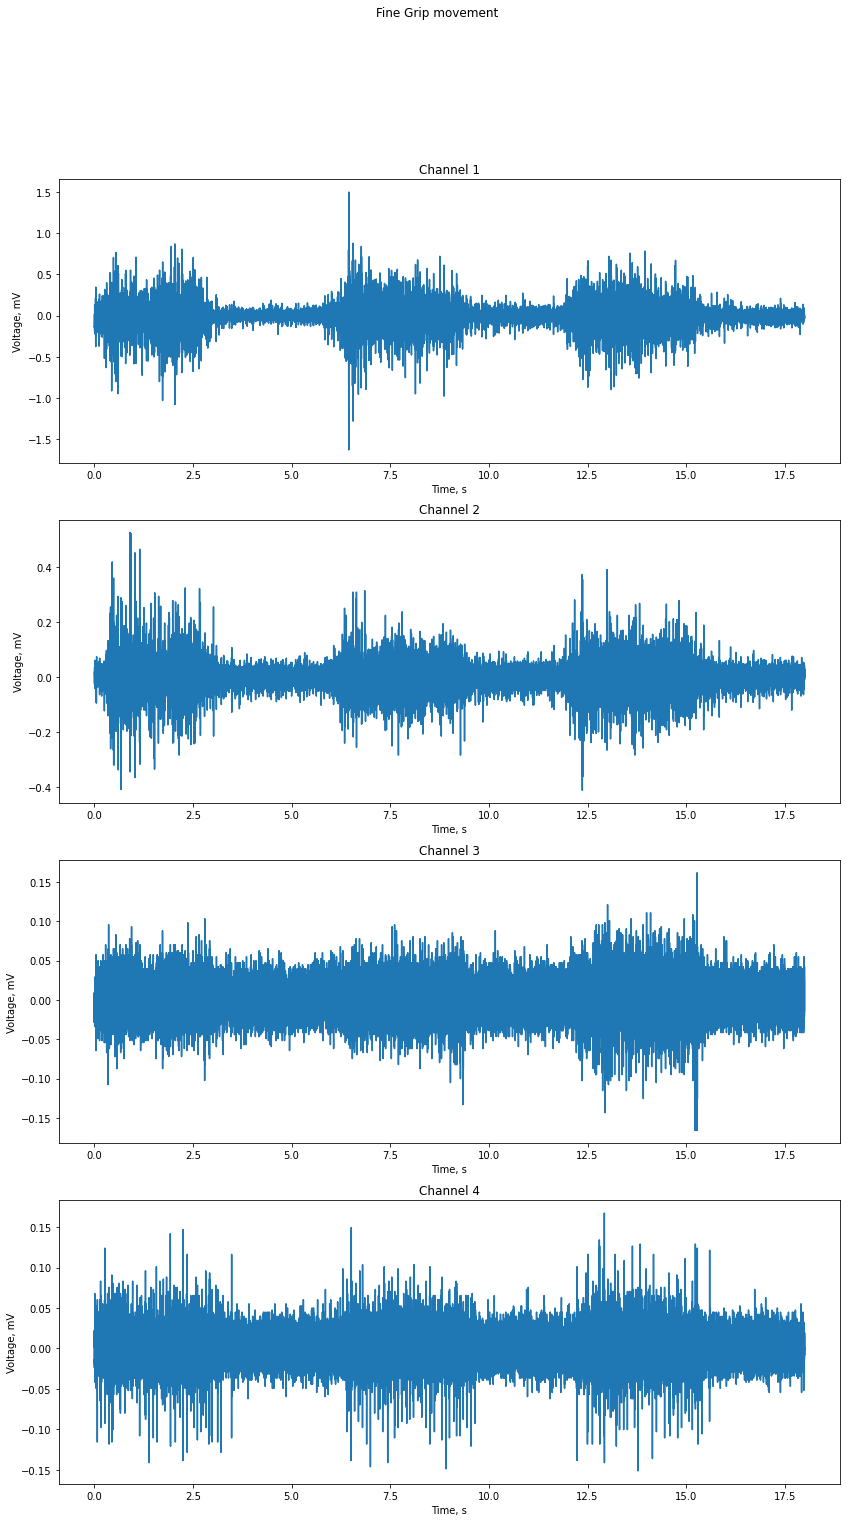

In [227]:
time = np.arange(0, sT, 1/sF)
plot_multiple_channel_signal(movements_dictionary['Fine Grip'], time, 'Fine Grip movement')

Amplitude spectrum for Fine Grip movement (on one channel).

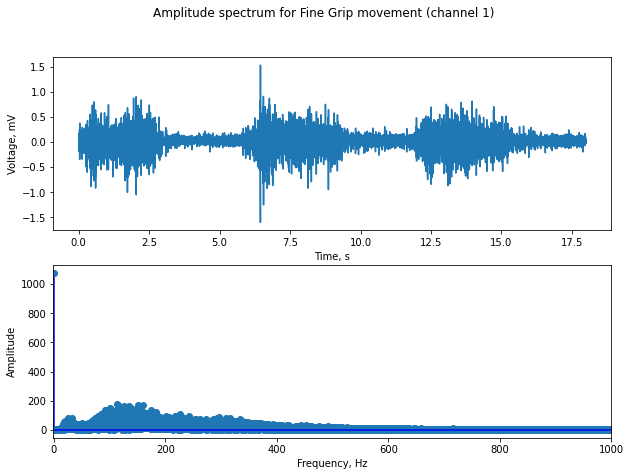

In [29]:
plot_signal_amplitude_spectrum(movements_dictionary['Fine Grip'][0], time, 'Amplitude spectrum for Fine Grip movement (channel 1)', sF)

Spectrogram for better understanding of the data.

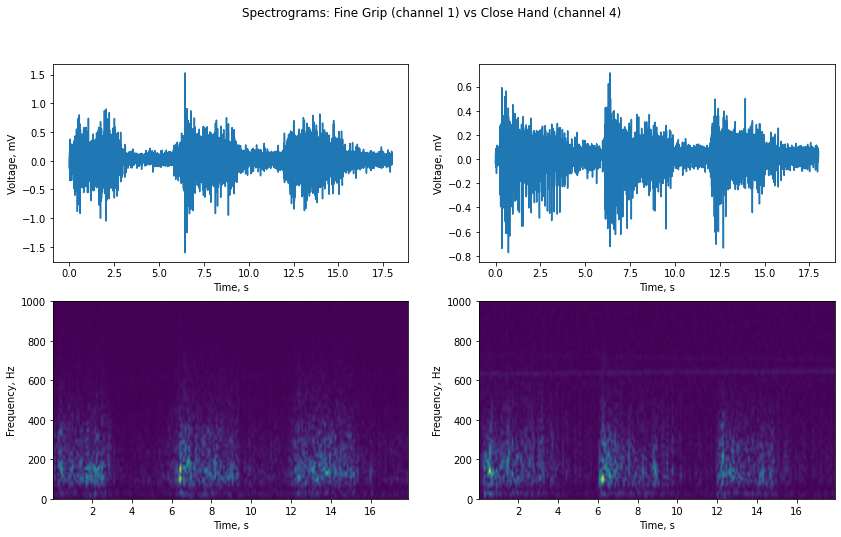

In [30]:
sig = movements_dictionary['Fine Grip'][0]
window = sp.signal.windows.blackmanharris(math.floor(0.1*sF))

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0, 0].plot(time, sig)
axs[0, 0].set(xlabel='Time, s', ylabel='Voltage, mV')

f, t, Sxx = sp.signal.spectrogram(sig, fs=sF, window=window, noverlap=None, mode='magnitude')
axs[1, 0].pcolormesh(t, f, Sxx, shading='gouraud')
axs[1, 0].set(xlabel='Time, s', ylabel='Frequency, Hz')

sig = movements_dictionary['Close Hand'][3]
axs[0, 1].plot(time, sig)
axs[0, 1].set(xlabel='Time, s', ylabel='Voltage, mV')

f, t, Sxx = sp.signal.spectrogram(sig, fs=sF, window=window, noverlap=None, mode='magnitude')
axs[1, 1].pcolormesh(t, f, Sxx, shading='gouraud')
axs[1, 1].set(xlabel='Time, s', ylabel='Frequency, Hz')

plt.suptitle("Spectrograms: Fine Grip (channel 1) vs Close Hand (channel 4)")
plt.show()

It is easy to spot that there are three repetitions of each movement.

Saving image:

In [407]:
fig_name = 'spectrograms.png'
fig.set_size_inches(w=14,h=8)
fig.savefig(fig_name, facecolor="lightgray")

Visualization of the signal processing pipeline on signal for Fine Grip movement.

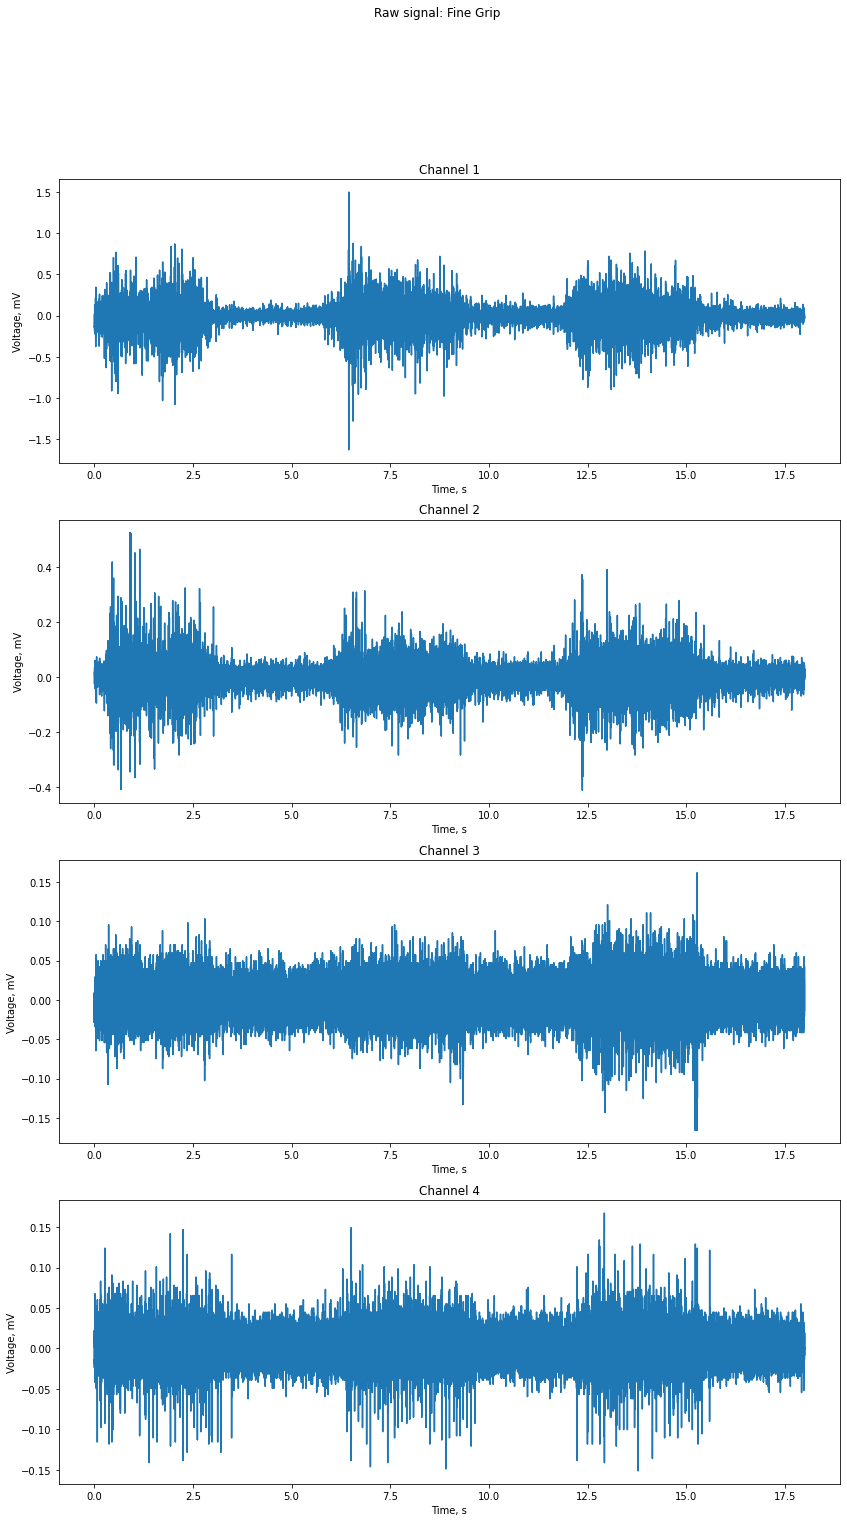

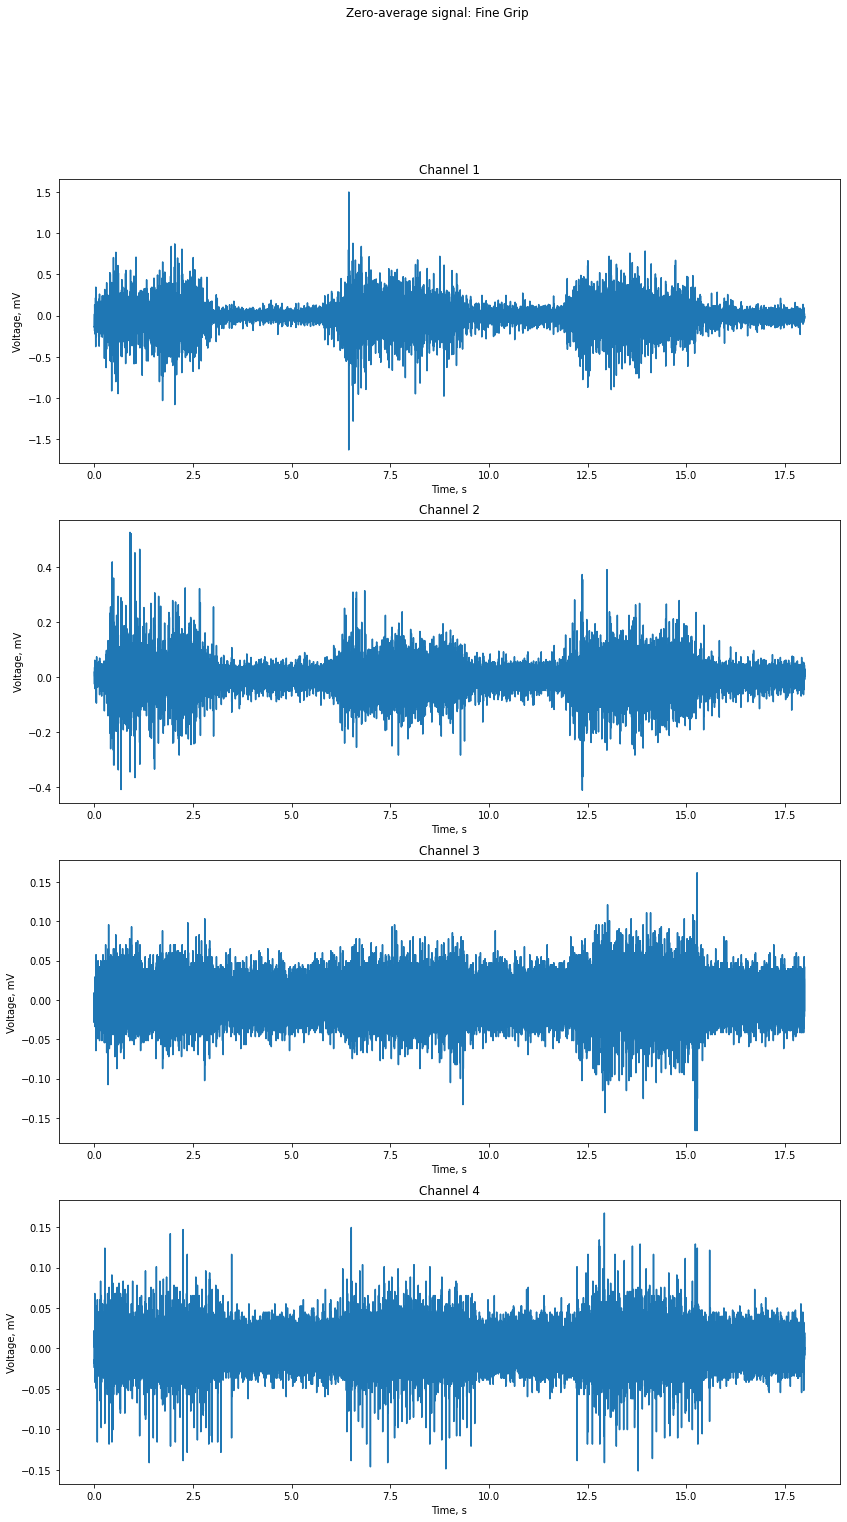

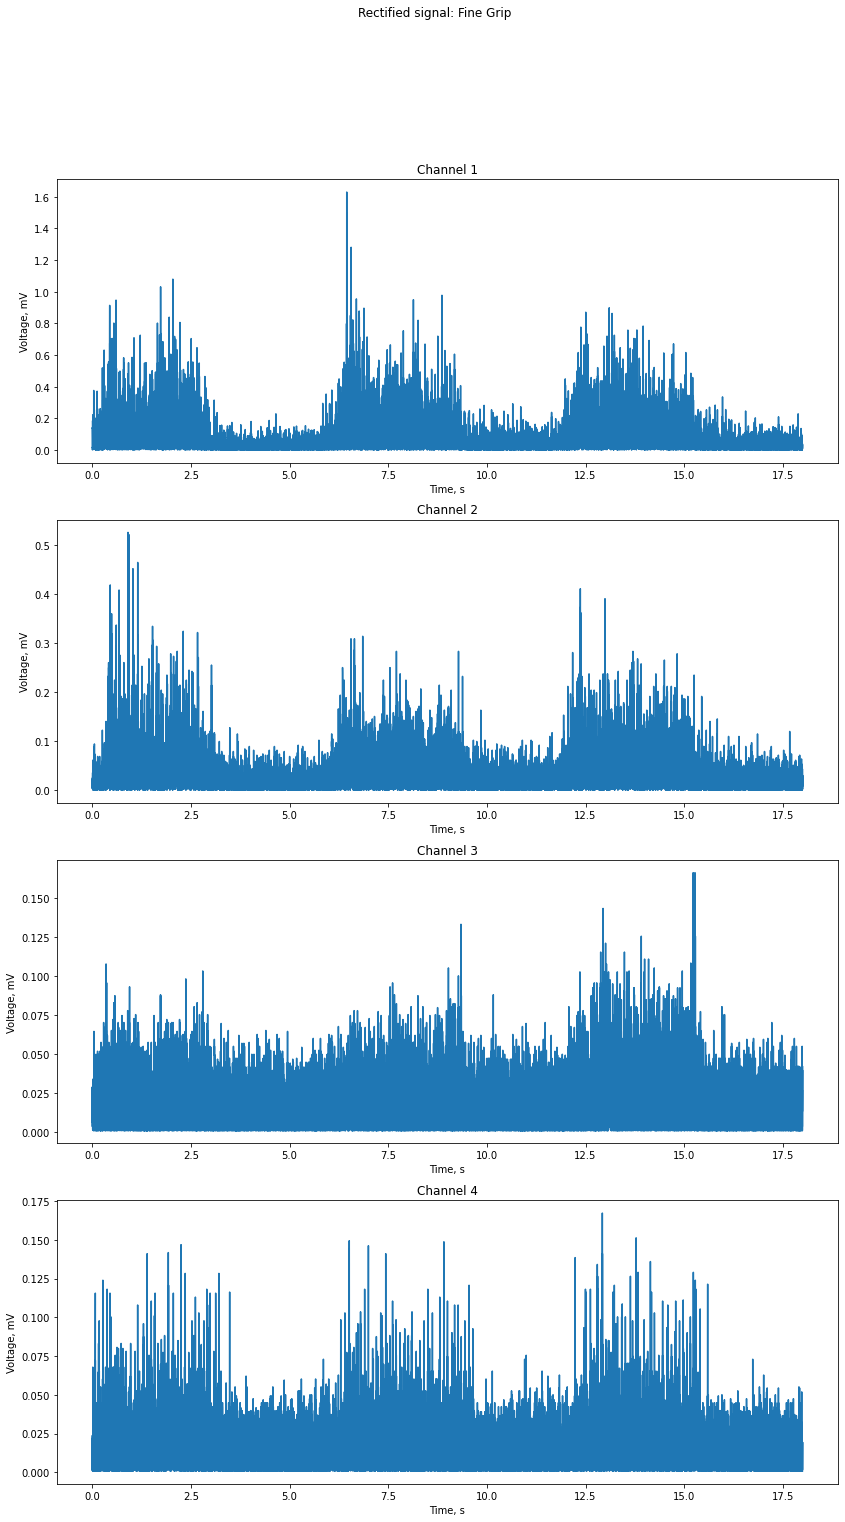

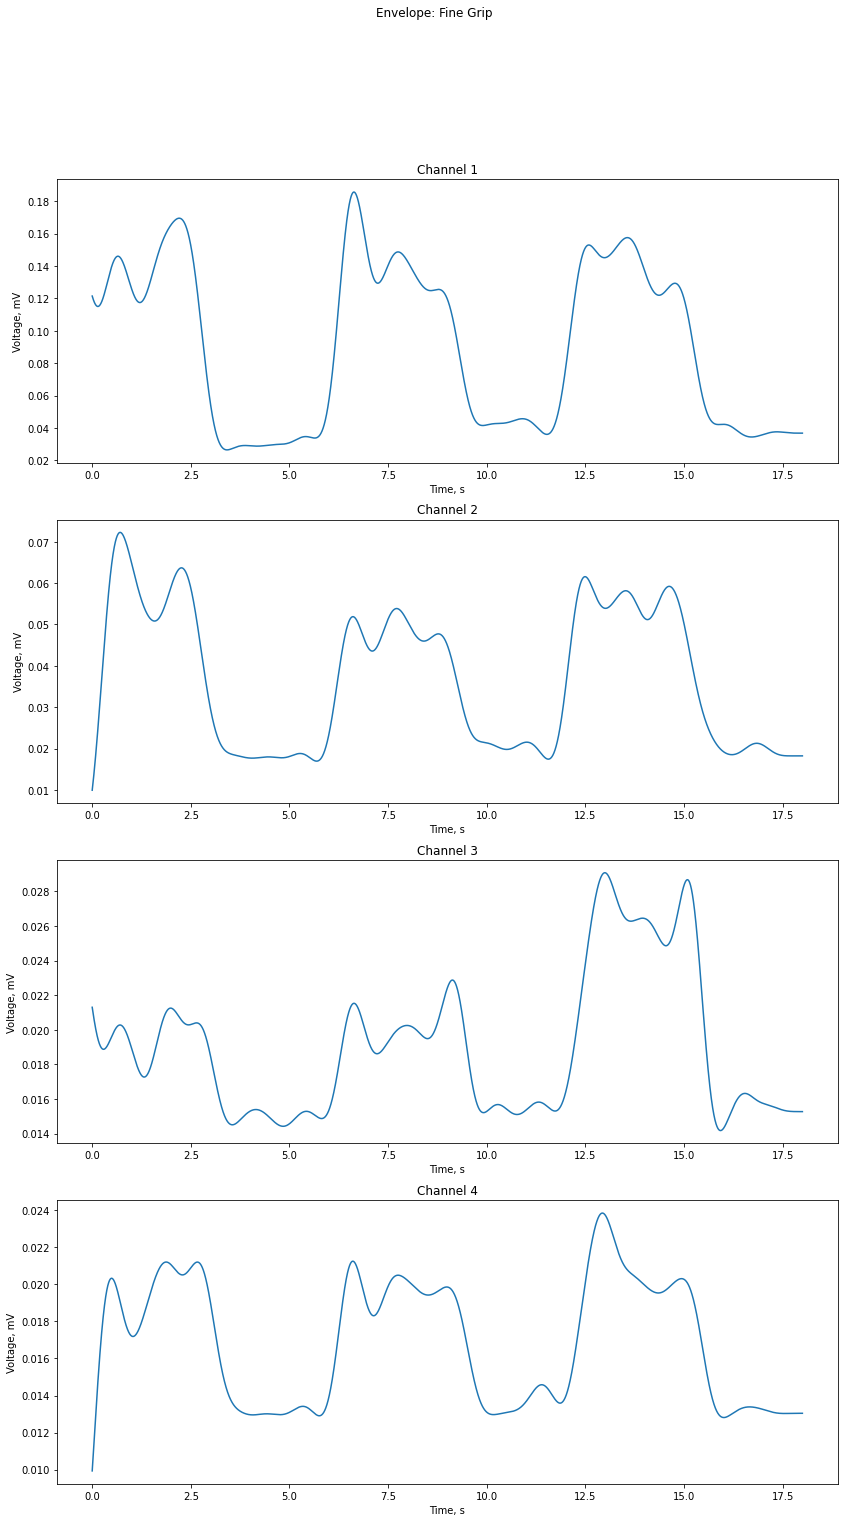

In [136]:
time = np.arange(0, sT, 1/sF) 
test_signal = movements_dictionary['Fine Grip']
processed_fine_grip = processing_pipeline(test_signal, time, sF, 'Fine Grip', 1, visualize=True)

Here is visualization of Open Hand movement processing for comparison.

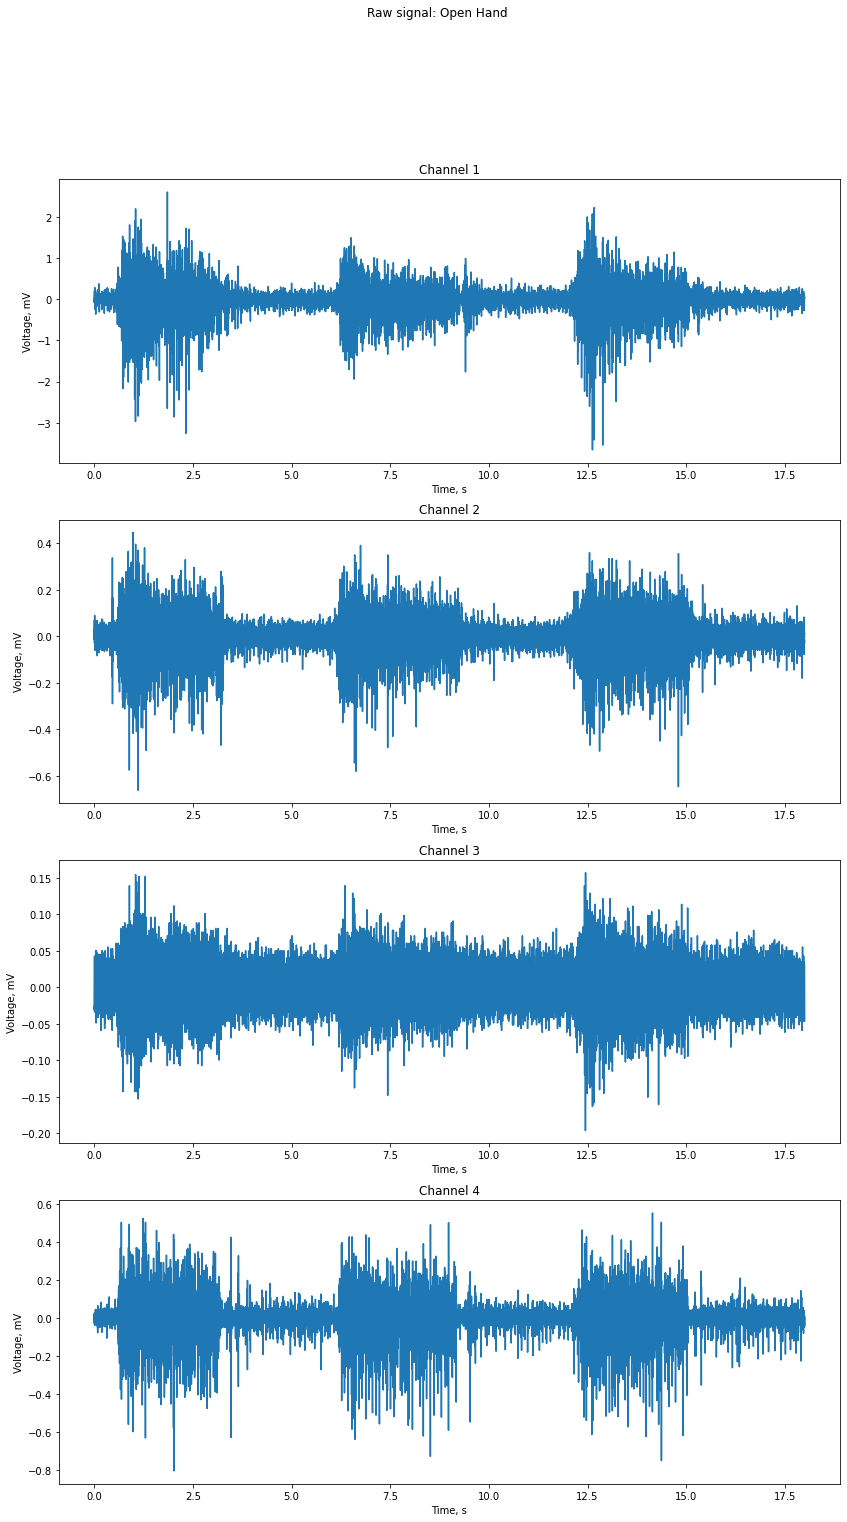

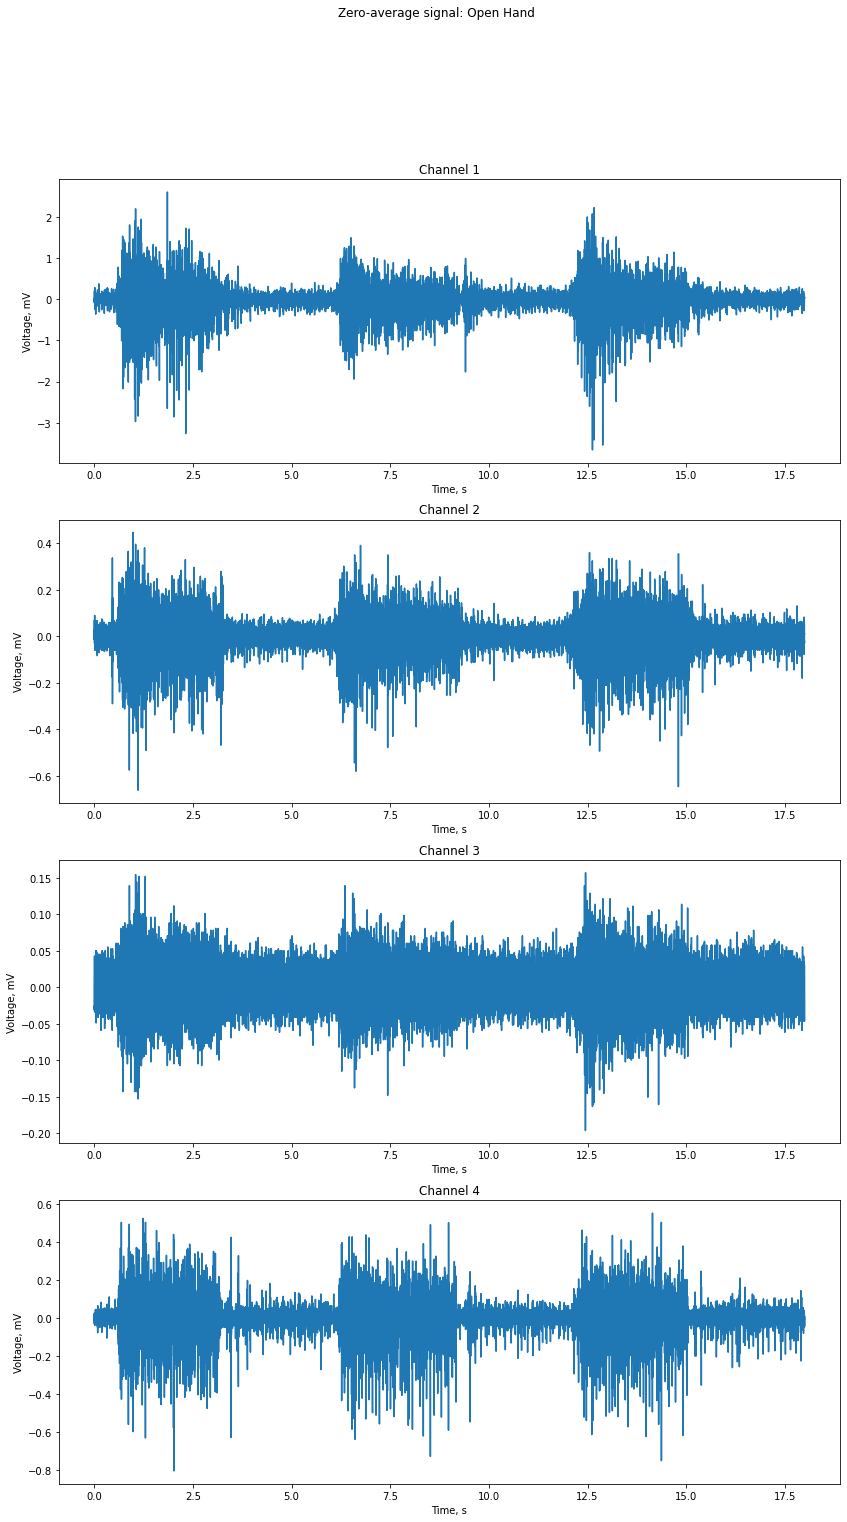

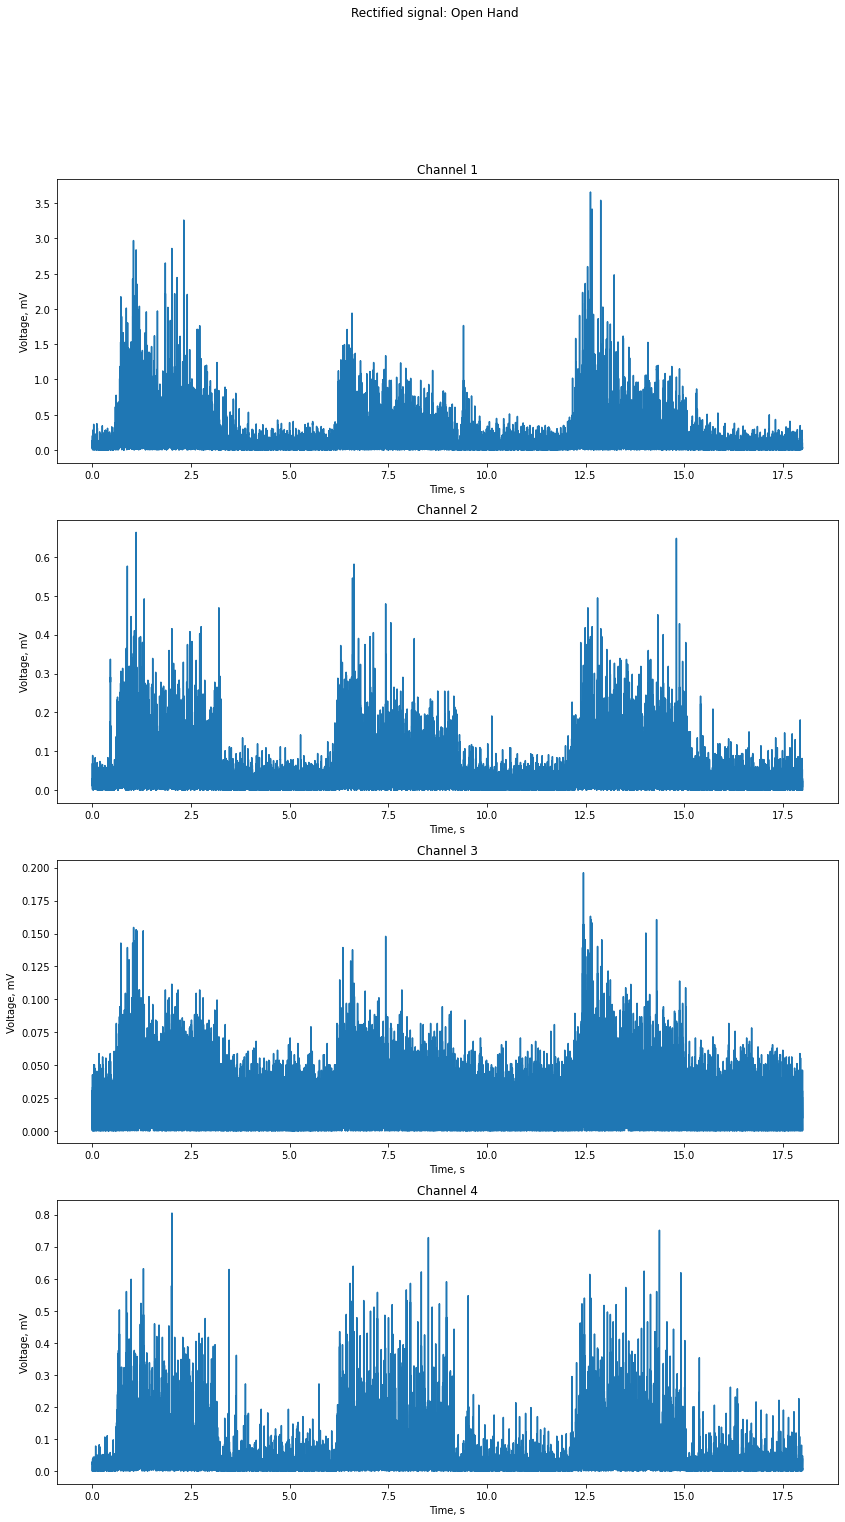

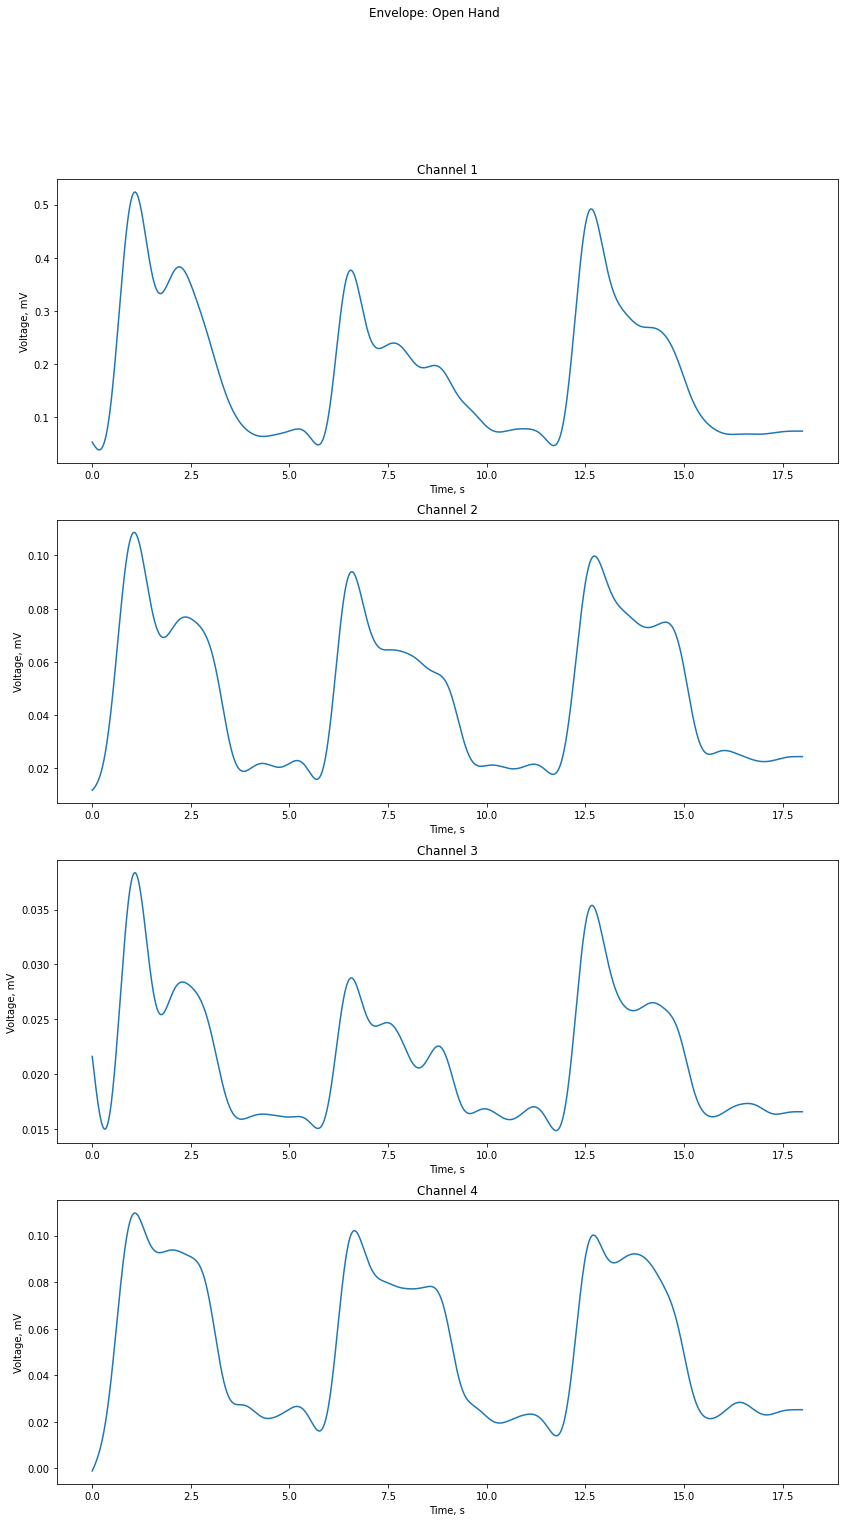

In [137]:
time = np.arange(0, sT, 1/sF) 
test_signal = movements_dictionary['Open Hand']
processed_open_hand = processing_pipeline(test_signal, time, sF, 'Open Hand', 1, visualize=True)

Visual comparison of signals for different movements in order to see which channel is the most important in order to see the difference between movements:

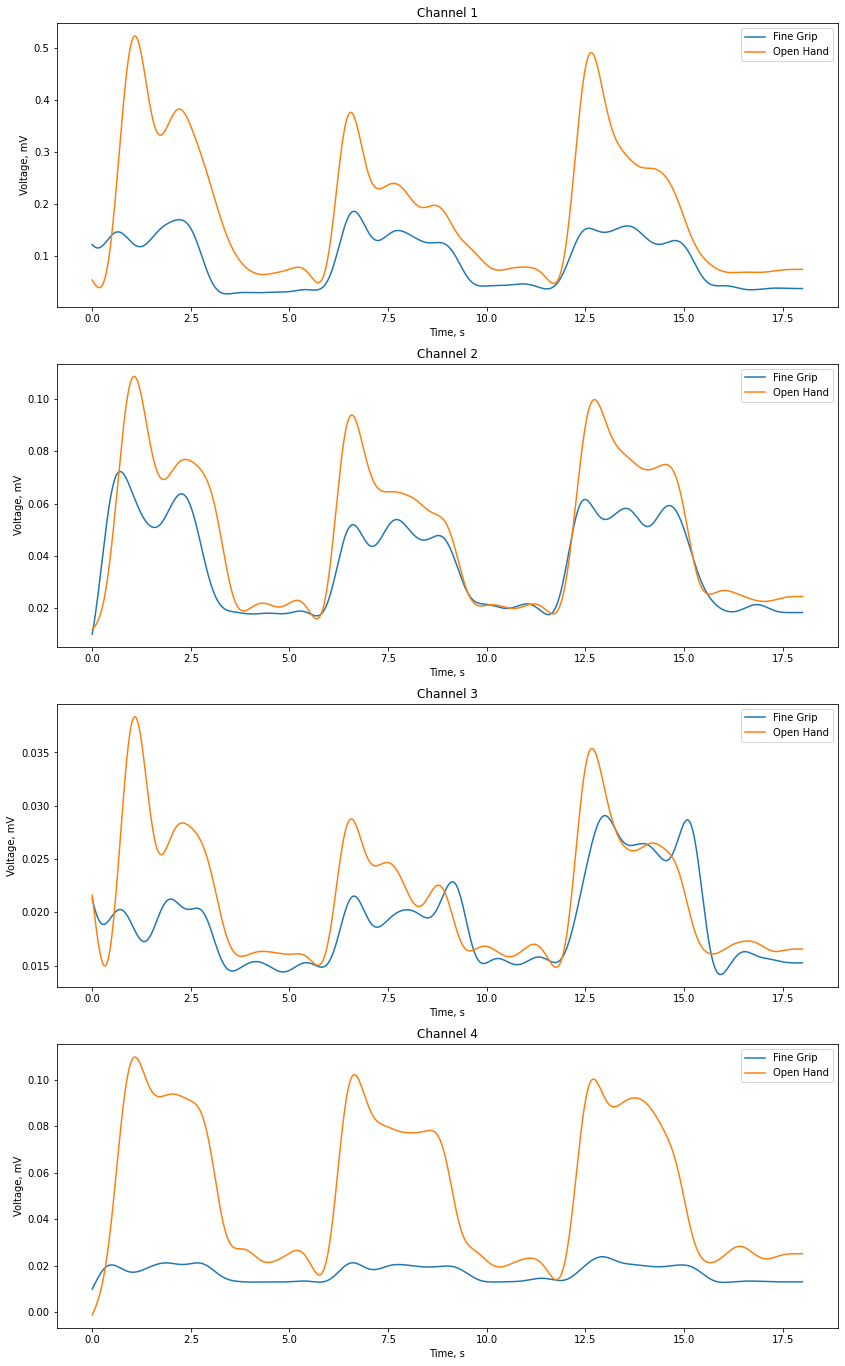

In [146]:
time = np.arange(0, sT, 1/sF) 
fig, ax = plt.subplots(4, 1, figsize=(14, 4*6))

for i in range(len(processed_fine_grip)):
    ax[i].plot(time, processed_fine_grip[i],  label='Fine Grip')
    ax[i].plot(time, processed_open_hand[i],  label='Open Hand')
    ax[i].set(xlabel='Time, s', ylabel='Voltage, mV', title=f'Channel {i+1}')
    ax[i].legend()  

Let's try for two other types of movements

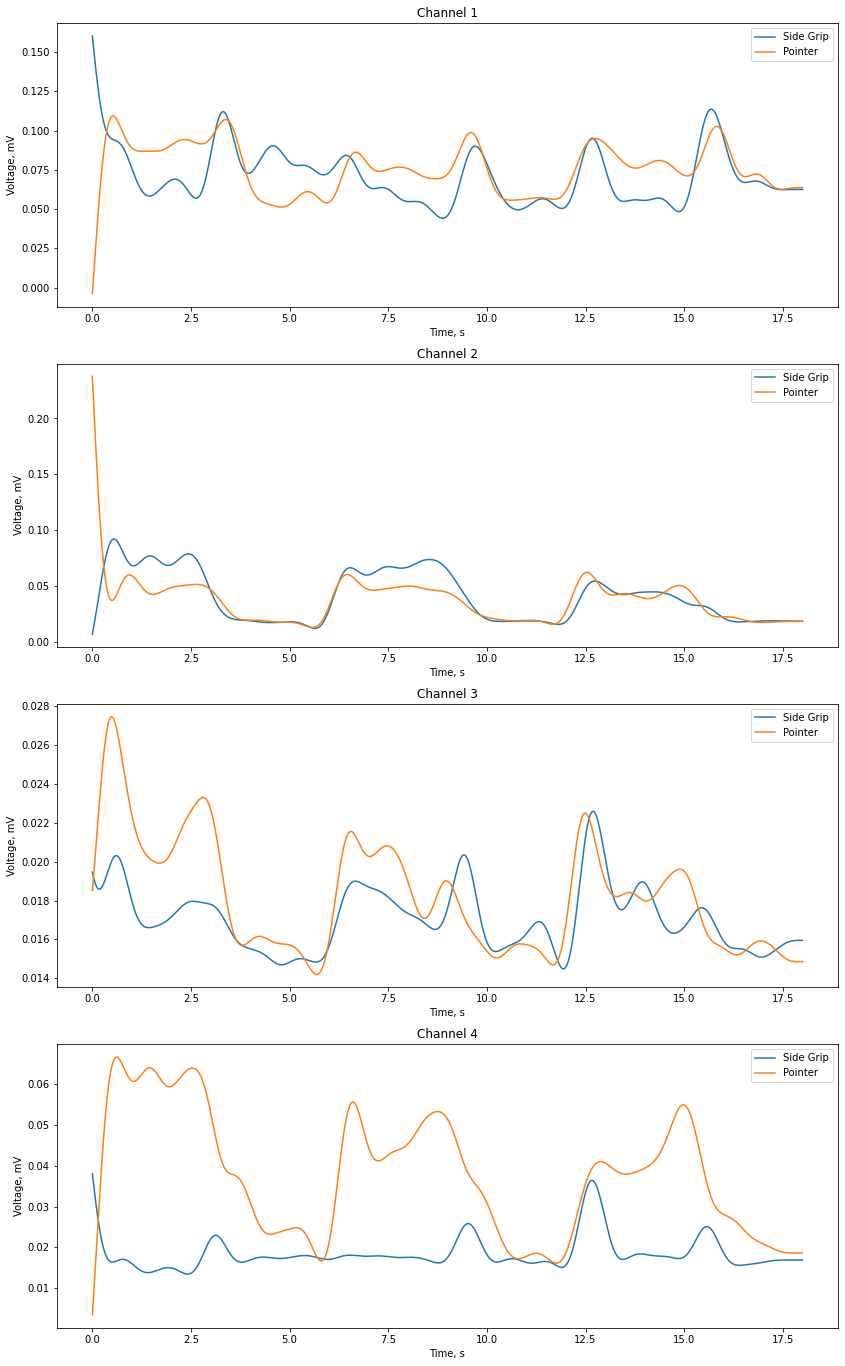

In [147]:
time = np.arange(0, sT, 1/sF) 
test_signal1 = movements_dictionary['Side Grip']
processed_1 = processing_pipeline(test_signal1, time, sF, 'Side Grip', 1, visualize=False)
test_signal2 = movements_dictionary['Pointer']
processed_2 = processing_pipeline(test_signal2, time, sF, 'Pointer', 1, visualize=False)

fig, ax = plt.subplots(4, 1, figsize=(14, 4*6))

for i in range(len(processed_1)):
    ax[i].plot(time, processed_1[i],  label='Side Grip')
    ax[i].plot(time, processed_2[i],  label='Pointer')
    ax[i].set(xlabel='Time, s', ylabel='Voltage, mV', title=f'Channel {i+1}')
    ax[i].legend() 

For both of them the most different were 4th channels, yet, even other channels showed differences, so I will use them all.

# II AI: Movement classification.

## Feature extraction for classification.

For feature extraction i chose following features, based on recommendations from my teacher and information from papers [Interpreting Deep Learning Features for Myoelectric Control: A Comparison With Handcrafted Features](https://www.frontiersin.org/articles/10.3389/fbioe.2020.00158/full) and [Myoelectric control of prosthetic hands: state-of-the-art review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4968852/):
1. Variance per channel
1. Number of ZCs (Zero crossing) per channel 
1. Maximum value per channel
1. Mean value per channel

So the final vector will have 4 instances of each feature:

```[Variance1, ..., ZC1, ..., Maximum, ..., Mean, ...]```

I will not take absolute values, because it already was a part of signal processing.

In [508]:
X_features = []

# counter = 0
for four_channel_signal in X:
    feature_vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    
    
    for i in range(len(four_channel_signal)):
        channel = four_channel_signal[i]
        
        # Variance per channel
        feature_vec[i] = statistics.variance(channel)
        
        # Zero crossing
        feature_vec[i + 4] = ((channel[:-1] * channel[1:]) < 0).sum()

        # Max value per channel
        feature_vec[i + 8] = np.max(channel)
    
        # Mean value per channel
        feature_vec[i + 12] = np.mean(channel)
    # counter+=1
    # print(counter)
    
    X_features.append(feature_vec)

## Classification.

Set and metrics functions:

In [509]:
class training_set(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X                           
        self.Y = Y                           

    def __len__(self):
        return len(self.X)                   

    def __getitem__(self, idx):
        return [torch.from_numpy(self.X[idx].copy()), self.Y[idx]]

In [510]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_features), y, test_size=0.2, random_state=42)

training_dataset = training_set(X_train, y_train)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=50, shuffle=True)
print("Size of Training dataset:", len(training_dataset))

testing_dataset = training_set(X_test, y_test)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=50, shuffle=True)
print("Size of Testing dataset:", len(testing_dataset))

Size of Training dataset: 160
Size of Testing dataset: 40


In [511]:
def metrics(model, X, y, name):
    kf = sklearn.model_selection.KFold(n_splits=5, random_state=None) 
    result = cross_val_score(model , X, y, cv = kf)
    print(f"Accuracy of the {name} model using k-folds cross-validation:", result.mean())
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print("Confusion matrix with simple train and test datasets:")
    return confusion_matrix(y_test, y_predicted)

def confusion_matrix(y_actual, y_predicted):
    confusion_matrix = pd.crosstab(pd.Series(y_actual, name='Actual'), pd.Series(y_predicted, name='Predicted'))
    confusion_matrix = confusion_matrix.set_axis([mov_labels[i] for i in confusion_matrix.columns], axis=1)
    confusion_matrix = confusion_matrix.set_axis([mov_labels[i] for i in confusion_matrix.index], axis=0)
    return confusion_matrix

Creating training and testing loaders.

Using the processed signal data, I will create a classification model to recognize available movements.

### Using Decision Tree Classifier.

Here I will use an algorithm from sklearn library.

In [512]:
dtree_model = DecisionTreeClassifier(max_depth = 10)

In [513]:
metrics(dtree_model, X_features, y, "Decision Tree")

Accuracy of the Decision Tree model using k-folds cross-validation: 0.39
Confusion matrix with simple train and test datasets:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,3,0,0,0,0,0,0,1,0,0
Flex Hand,1,0,2,0,0,0,0,0,0,1
Extend Hand,0,0,0,1,0,0,0,0,0,0
Pronation,0,0,0,0,4,0,1,0,0,0
Supination,1,2,1,0,0,2,0,3,0,1
Side Grip,0,1,0,0,1,0,0,2,0,1
Fine Grip,0,0,0,0,0,0,0,2,0,1
Agree,1,1,0,0,0,1,0,0,2,1
Pointer,1,1,0,0,0,0,0,0,0,0


### Using SVM

In [514]:
svm_model_linear = SVC(kernel = 'linear')

In [515]:
metrics(svm_model_linear, X_features, y, "SVM")

Accuracy of the SVM model using k-folds cross-validation: 0.225
Confusion matrix with simple train and test datasets:


,Close Hand,Flex Hand,Extend Hand,Pronation,Fine Grip,Pointer
Open Hand,1,0,1,0,2,0
Flex Hand,2,1,0,0,1,0
Extend Hand,0,0,1,0,0,0
Pronation,0,1,0,1,2,1
Supination,1,0,1,0,5,3
Side Grip,1,0,0,0,4,0
Fine Grip,0,0,0,0,3,0
Agree,1,0,0,0,5,0
Pointer,1,0,0,0,1,0


### Using KNN (k-nearest neighbors) classifier

In [516]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [517]:
metrics(knn, X_features, y, "KNN")

Accuracy of the KNN model using k-folds cross-validation: 0.26499999999999996
Confusion matrix with simple train and test datasets:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,2,1,0,1,0,0,0,0,0,0
Flex Hand,1,0,2,0,0,0,0,0,0,1
Extend Hand,0,0,0,1,0,0,0,0,0,0
Pronation,0,1,0,0,2,0,0,0,1,1
Supination,4,2,0,1,0,2,0,1,0,0
Side Grip,2,1,0,0,1,1,0,0,0,0
Fine Grip,0,0,0,0,0,0,1,1,0,1
Agree,3,1,0,0,0,1,0,0,1,0
Pointer,1,0,1,0,0,0,0,0,0,0


### Using Naive Bayes classifier

In [518]:
gnb = GaussianNB()

In [519]:
metrics(gnb, X_features, y, "Naive Bayes classifier")

Accuracy of the Naive Bayes classifier model using k-folds cross-validation: 0.335
Confusion matrix with simple train and test datasets:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree
Open Hand,1,0,0,1,0,0,2,0,0
Flex Hand,1,1,1,0,0,0,0,0,1
Extend Hand,0,0,0,1,0,0,0,0,0
Pronation,0,0,0,0,4,0,0,0,1
Supination,0,1,0,1,0,1,4,2,1
Side Grip,1,0,0,0,0,0,1,3,0
Fine Grip,0,0,0,0,0,0,1,2,0
Agree,0,1,0,0,0,0,0,4,1
Pointer,2,0,0,0,0,0,0,0,0


### Using Neural Network.

Training an MLP (Multilayer Perceptron) model:

In [520]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, initial_size):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(initial_size, 14)
        self.layer_2 = nn.Linear(14, 12)
        self.layer_3 = nn.Linear(12, 10)
        # self.layer_2 = nn.Linear(1000, 100)
        # self.layer_3 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.layer_1(x.float())
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x    

In [521]:
model = MLP(initial_size = len(X_features[0])).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 20

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x_var, y_var = input_data
        x_var = x_var.to(device).float()
        y_var = y_var.to(device)

        output = model(x_var)
        loss = criterion(output, y_var)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        if batch_num % 40 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

	Epoch 0 | Batch 0 | Loss   2.29
Epoch 0 | Loss   2.29
	Epoch 1 | Batch 0 | Loss   2.28
Epoch 1 | Loss   2.28
	Epoch 2 | Batch 0 | Loss   2.30
Epoch 2 | Loss   2.27
	Epoch 3 | Batch 0 | Loss   2.23
Epoch 3 | Loss   2.25
	Epoch 4 | Batch 0 | Loss   2.22
Epoch 4 | Loss   2.25
	Epoch 5 | Batch 0 | Loss   2.20
Epoch 5 | Loss   2.25
	Epoch 6 | Batch 0 | Loss   2.25
Epoch 6 | Loss   2.19
	Epoch 7 | Batch 0 | Loss   2.20
Epoch 7 | Loss   2.20
	Epoch 8 | Batch 0 | Loss   2.22
Epoch 8 | Loss   2.15
	Epoch 9 | Batch 0 | Loss   2.13
Epoch 9 | Loss   2.21
	Epoch 10 | Batch 0 | Loss   2.13
Epoch 10 | Loss   2.17
	Epoch 11 | Batch 0 | Loss   2.14
Epoch 11 | Loss   2.19
	Epoch 12 | Batch 0 | Loss   2.05
Epoch 12 | Loss   2.19
	Epoch 13 | Batch 0 | Loss   2.19
Epoch 13 | Loss   2.15
	Epoch 14 | Batch 0 | Loss   2.14
Epoch 14 | Loss   2.16
	Epoch 15 | Batch 0 | Loss   2.14
Epoch 15 | Loss   2.16
	Epoch 16 | Batch 0 | Loss   2.21
Epoch 16 | Loss   2.09
	Epoch 17 | Batch 0 | Loss   2.16
Epoch 17 | Loss  

Model evaluation.

In [522]:
model.eval()
total_loss = 0
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(testing_loader):
        output = model(data)
        loss = F.cross_entropy(output, target) 
        total_loss += loss.item()
        correct += (output.argmax(1) == target).type(torch.float).sum().item()
        show_output = output.argmax(1)
        # print(f"Expected   vs    Got")
        # for i in range(len(target)):
        #     print(mov_labels[target[i]], "   ", mov_labels[show_output[i]])

print('Testing: Epoch average loss {:.6f}'.format(total_loss/len(testing_loader.dataset)))
print(f"         Accuracy: {(100*(correct/len(testing_loader.dataset))):>0.1f}%")

Testing: Epoch average loss 0.055673
         Accuracy: 15.0%


In [523]:
final_prediction = model(torch.from_numpy(np.array(X_test)))
print("Accuracy of the MLP model:", sklearn.metrics.accuracy_score(y_test, final_prediction.argmax(1)))
confusion_matrix(y_test, final_prediction.argmax(1))
# metrics(model, X_features, y, "Neural Network")

Accuracy of the MLP model: 0.15


,Close Hand,Flex Hand,Extend Hand,Fine Grip
Open Hand,0,0,2,2
Flex Hand,0,2,1,1
Extend Hand,0,0,1,0
Pronation,0,3,0,2
Supination,1,2,5,2
Side Grip,0,0,1,4
Fine Grip,0,0,0,3
Agree,0,0,2,4
Pointer,0,1,1,0
